In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import kali.carma
import kali
from lsstlc import * # derived LSST lightcurve sub-class

/home/kali/python/kali/lc.py:29: UserWarning: No display environment! Using matplotlib backend "Agg"
  warnings.warn('No display environment! Using matplotlib backend "Agg"')
/home/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Generate DHO from DDF sampling rate

In [2]:
# import ddf cadence
ddf = np.load('/home/mount/MAF output/ddf_Elias.npz')
cadence = ddf['cadence']
gap = float(ddf['gap'])

In [27]:
# initiate DHO parameters
Task = kali.carma.CARMATask(2,1,nsteps = 1000)

# pick root values and amplitude (copyed from Kali's introduction notebook)

# "Let us set the first C-ARMA model in the Task object to have an autocorrelation \
# function that decays with two timescales - 107.8 d and 43.2 d. We shall set the MA timescale to be 5.5 d \
# and set the amplitude of the light curve (i.e. the square root of the asymptotic autocorrelation function) 
# to be 1.0" - direct quote from Kali's introduction notebook
r_1 = (-1.0/107.8) + 0j
r_2 = (-1.0/33.2) + 0j
m_1 = (-1.0/5.5) + 0j
amp = 1.0

Rho = np.array([r_1, r_2, m_1, amp]) # put the selected paramenters into array format
Theta = kali.carma.coeffs(2, 1, Rho) # use the array of roots above to solve for coefficients
print Theta # print out the calculated coefficients
print Task.check(Theta) # check whether computed coefficients make sense, if True then OK

[ 0.03939692  0.00027941  0.0046724   0.0256982 ]
True


In [28]:
# convert min_gap from hours to days
dt = gap/24

# set CARMA task paremeters: 
# dt: sampling rate (one data point every dt), where the min_gap is used
# Theta: coefficients for the CARMA model obtained above
Task.set(dt, Theta)

# generate mock lightcurve, duration 10 years, using dt, Theta and of course also p=2, q=1
LC = Task.simulate(duration=3650)

In [29]:
# add simulated noise into lc, based on the c++ code of Kali, the noise is generated using a gaussian
# random number generator, with mean=0, variance=flux*fracNoiseToSignal, where fracNoiseToSignal defaults to 0.001
LC.fracNoiseToSignal = 0.01
Task.observe(LC)

In [30]:
# we can make up ra and dec, which doesn't matter
dLC = lsstlc(10, 10, cadence['expDate'], LC, gap)

In [8]:
import pandas as pd

In [31]:
# put everything into pandas dataframe
df = pd.DataFrame.from_records(cadence)
df['obsTimes'] = dLC.t
df['abrFlux'] = dLC.y
df['fluxErr'] = dLC.yerr

In [32]:
# export pandas to csv
df.to_csv('/home/mount/lsst_cadence/DDF/dho_lc.csv',index=False)

### Generate DRW LC from DDF sampling

In [20]:
Task_drw = kali.carma.CARMATask(1,0,nsteps = 1000)
r_1_drw = (-1.0/150.0) + 0j 
amp_drw = 1.0
Rho_drw = np.array([r_1, amp])

# use helper function to convert input to coefficients, and check whether valid
Theta_drw = kali.carma.coeffs(1, 0, Rho_drw) # use the array of roots above to solve for coefficients
print Theta_drw # print out the calculated coefficients
print Task_drw.check(Theta_drw)

[ 0.00666667  0.11547005]
True


In [21]:
# set parameter
Task_drw.set(dt,Theta_drw)

0

In [22]:
# simulate lc with 100 SNR
DRW_lc = Task.simulate(duration=3650)
DRW_lc.fracNoiseToSignal = 0.01
Task.observe(DRW_lc)

In [24]:
d_drw = lsstlc(10, 10, cadence['expDate'], DRW_lc, gap)

In [25]:
# put all data into pandas 
df_drw = pd.DataFrame.from_records(cadence)
df_drw['obsTimes'] = d_drw.t
df_drw['abrFlux'] = d_drw.y
df_drw['fluxErr'] = d_drw.yerr

In [26]:
# export pandas to csv
df.to_csv('/home/mount/lsst_cadence/DDF/drw_lc.csv',index=False)

## How to use my output

Just use pandas to read csv into a dataframe. Dataframe is like a table, there is a lot you can do with it. Below I will show how you can use my data to plot light curve. By the way, the three addional columns that I added to the end are:  
- **obsTimes:** Observation times in days, the expDate equivalent.  
- **abrFlux:** The flux of the object, with an arbitrary unit (doesn't matter too much I guess).  
- **fluxErr:** Simulated observation error in terms of flux.

In [33]:
df_drw = pd.read_csv('/home/mount/lsst_cadence/DDF/drw_lc.csv') # change the path to your directory

In [36]:
# show first 5 rows here
df_drw.head(5)

,expDate,night,expMJD,fiveSigmaDepth,filter,obsTimes,abrFlux,fluxErr
0,15589304,180,59760.431760,22.088572,z,0.000000,6.544304,0.065467
1,15590450,180,59760.445023,22.037498,z,0.013312,6.452222,0.065471
2,16446700,190,59770.355327,21.921016,y,9.923680,6.845609,0.068288
3,16447291,190,59770.362167,24.264669,r,9.930336,6.803676,0.068295
4,16447328,190,59770.362595,24.271422,r,9.930752,6.748217,0.068293


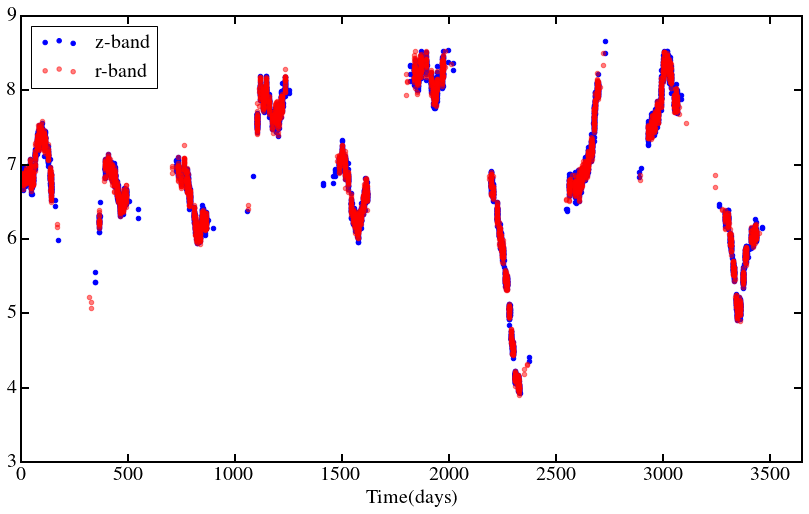

In [53]:
# now let us plot the light curve for all z and r filters
fig = plt.figure(figsize=(14,8))
where = df['filter'] == 'z'
where_r = df['filter'] == 'r'
plt.xlabel('Time(days)')
plt.scatter(df['obsTimes'][where], df['abrFlux'][where], color = 'b',label='z-band')
plt.scatter(df['obsTimes'][where_r], df['abrFlux'][where_r], color = 'r', alpha=0.5, label='r-band')
plt.xlim(0, 3650)
plt.legend(loc=2)

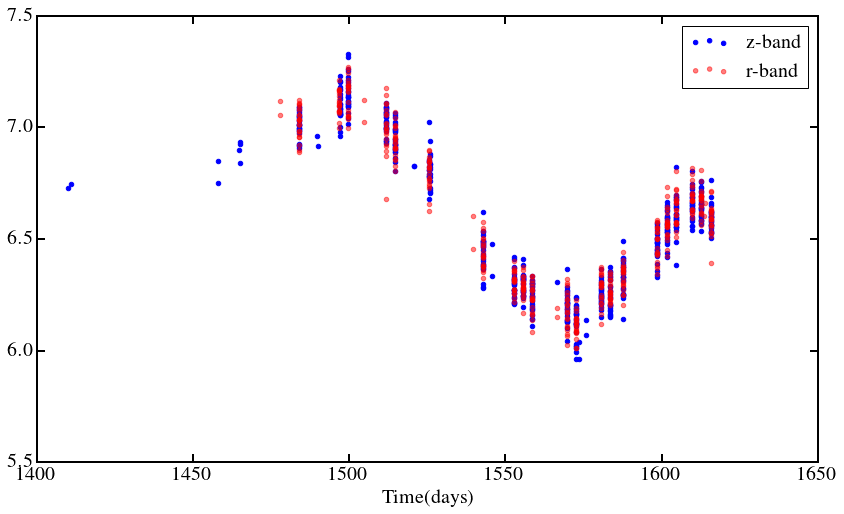

In [54]:
# zoom in look
fig = plt.figure(figsize=(14,8))
where = df['filter'] == 'z'
where_r = df['filter'] == 'r'
plt.xlabel('Time(days)')
plt.scatter(df['obsTimes'][where], df['abrFlux'][where], color = 'b', label='z-band')
plt.scatter(df['obsTimes'][where_r], df['abrFlux'][where_r], color = 'r', alpha=0.5, label='r-band')
plt.xlim(1400, 1650)
plt.ylim(5.5, 7.5)
plt.legend()

## At the end:

Just be careful with one thing, the data type for filter might mess up when you try to select certain bands by comparing with a string. That is becuase Python 2 and 3 are using different data types for string. If anything go wrong in that manner, it is possibly the data types. Python 3 might be smart enough to handle it, I don't know. If you use python 2, everything should work as shown above. 